In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [2]:
df_initial = pd.read_csv("dataframe_nettoye.csv")


In [3]:
df_initial = df_initial.dropna(subset=["RevLineCr"])


In [4]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score


# métriques
def metriques(pipeline, X_test, y_test) :
    y_pred = pipeline.predict(X_test)
    
    # Métriques d'évaluation
    print("Accuracy Score:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    f1_macro = f1_score(y_test, y_pred, average='macro')
    print(f"F1-score macro : {f1_macro}")

    matrice_confusion = confusion_matrix(y_test, y_pred)
    matrice_percentage = matrice_confusion.astype('float') / matrice_confusion.sum(axis=1)[:, np.newaxis] * 100
    matrice_percentage
    
# courbe AUC
def courbe_AUC(pipeline, X_test, y_test) :
    from sklearn.metrics import roc_curve, auc
    y_pred_proba = pipeline.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
def best_params_to_csv(random_search):
    nom_classifier = random_search.estimator.named_steps[list(random_search.estimator.named_steps.keys())[-1]].__class__.__name__
    params_top = pd.DataFrame([random_search.best_params_])
    params_top.to_csv(f"best_params_{nom_classifier}.csv", index=False)


In [5]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler


df = df_initial.copy()

df["MIS_Status"] = df["MIS_Status"].map({"CHGOFF": 0, "P I F": 1})
df["LowDoc"] = df["LowDoc"].map({"Y" : 1, "N" : 0})

features = ["City", "State", "Zip", "Bank", "BankState", "NAICS", "ApprovalFY", "Term", "NoEmp", "NewExist", "CreateJob", "RetainedJob", "FranchiseCode", "UrbanRural", "LowDoc", "DisbursementGross","GrAppv", "RevLineCr", "SBA_Appv", "bool_RetainedJob",  "bool_CreateJob", "Recession"]

X = df[features]
y = df['MIS_Status']

num_col = ['ApprovalFY', 'Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'DisbursementGross', 'GrAppv']


numeric_transformer = Pipeline([
    # ('scaler', RobustScaler())])
    ('scaler', StandardScaler())])

def transform_naics(X):
    return X['NAICS'].astype(str).str[:2].astype(int).values.reshape(-1, 1)

def transform_franchise(X):
    return X['FranchiseCode'].apply(lambda x: 1 if x in [0, 1] else 0).values.reshape(-1, 1)

# preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("naics_2_nb", FunctionTransformer(transform_naics), ['NAICS']),
        ("franchise_transform", FunctionTransformer(transform_franchise), ['FranchiseCode']),
        ('num', numeric_transformer, num_col),
    ],
    remainder='drop')

# pipeline
def creer_pipeline(model) :
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    return pipeline


In [6]:
lightgbm_best_params = pd.read_csv("best_params_LGBMClassifier.csv")


In [7]:
lightgbm_best_params

,classifier__num_leaves,classifier__n_estimators,classifier__min_gain_to_split,classifier__min_data_in_leaf,classifier__max_depth,classifier__max_bin,classifier__learning_rate,classifier__lambda_l2,classifier__lambda_l1,classifier__feature_fraction,classifier__class_weight,classifier__bagging_freq,classifier__bagging_fraction
0,20,500,0.2,10,4,510,0.251189,1.0,0.75,0.8,NaN,10,0.8


In [8]:
lightgbm_params = {col.replace('classifier__', ''): val for col, val in lightgbm_best_params.iloc[0].items()}
del lightgbm_params["class_weight"]
# lightgbm_params["scale_pos_weight"] = 0.9
# lightgbm_params["max_depth"] = 10
# lightgbm_params["n_estimators"] = 60
# lightgbm_params["num_leaves"] = 16
# lightgbm_params["bagging_fraction"] = 0.82
# lightgbm_params["lambda_l2"] = 0.9
# lightgbm_params["min_data_in_leaf"] = 11


for key in ["num_leaves", "n_estimators", "min_data_in_leaf", "max_depth", "max_bin", "bagging_freq"]:
    lightgbm_params[key] = int(lightgbm_params[key])
lightgbm_params

{'num_leaves': 20,
 'n_estimators': 500,
 'min_gain_to_split': 0.2,
 'min_data_in_leaf': 10,
 'max_depth': 4,
 'max_bin': 510,
 'learning_rate': 0.2511886431509579,
 'lambda_l2': 1.0,
 'lambda_l1': 0.75,
 'feature_fraction': 0.8,
 'bagging_freq': 10,
 'bagging_fraction': 0.8}

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
print("Colonnes catégoriques :", categorical_features)


Colonnes catégoriques : ['City', 'State', 'Bank', 'BankState', 'RevLineCr']


In [11]:
light_gbm_best = lgb.LGBMClassifier(
    # device="cuda",
    **lightgbm_params,
    objective='binary',
    eval_metric=['auc', 'logloss'],
    random_state=42,
    n_jobs=-1
)

# Créer la pipeline finale
best_pipeline_lightgbm = creer_pipeline(light_gbm_best)


In [12]:
best_pipeline_lightgbm.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0.2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2
[LightGBM] [Warning] lambda_l1 is set=0.75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.75
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Cur

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('naics_2_nb',
                                                  FunctionTransformer(func=<function transform_naics at 0x0000015E042BDE40>),
                                                  ['NAICS']),
                                                 ('franchise_transform',
                                                  FunctionTransformer(func=<function transform_franchise at 0x0000015E042BE3E0>),
                                                  ['FranchiseCode']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['ApprovalFY', 'Ter...
                                                   'DisbursementGross',
                                                   'GrAppv'])])),
                ('classifier',
                 LGBMClassifier(bagging_fraction=0.8, bagging_freq=10,
                                eval_metric=['auc', 'logloss'],
                                feature_fraction=0.8, lambda_l1=0.75,
                                lambda_l2=1.0, learning_rate=0.2511886431509579,
                                max_bin=510, max_depth=4, min_data_in_leaf=10,
                                min_gain_to_split=0.2, n_estimators=500,
                                n_jobs=-1, num_leaves=20, objective='binary',
                                random_state=42))])

In [13]:
metriques(best_pipeline_lightgbm, X_test, y_test)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0.2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2
[LightGBM] [Warning] lambda_l1 is set=0.75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.75
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Accuracy Score: 0.9500148789177799

Classification Report:
              precision    recall  f1-score   support

           0       0.88     

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0.2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2
[LightGBM] [Warning] lambda_l1 is set=0.75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.75
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


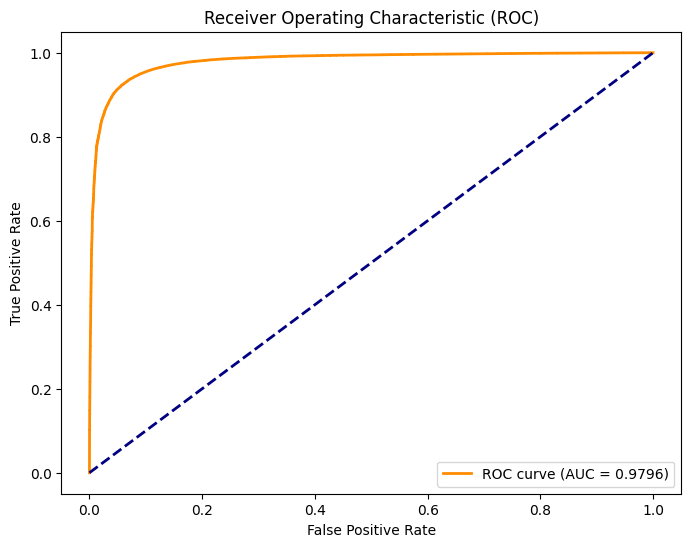

In [14]:
courbe_AUC(best_pipeline_lightgbm, X_test, y_test)